##### Advanced Statistical Analysis and Model-Based Learning (Fall 2024-2025)
# Home Assignment 5

#### Due: 27/01/2025 by 18:30

#### Instructions:
- Write your name, Student ID, and date in the cell below. 
- Submit a copy of this notebook with code filled in the relevant places as the solution of coding excercises.
- For theoretic excercises, you can either write your solution in the notebook using $\LaTeX$ or submit additional notes.

<hr>
<hr>

<hr>
<hr>

## Problem 1: Multiple Regression

Use the attached cars dataset that was used in the EDA notebook. Load it using the function `load_cars_data`. We will use `MSRP` as the target variable (note that this is a transformed version of the original MSRP).

1. Use all variables in the data returned by `load_cars_data`. Find at least one pair of competing predictors.
2. A car manufacturer is trying to figure out how to design a new vehicle for maximal profitability. They propose that since `EngineCylinders` is correlated with `MSRP`, they should try to maximize engine cylinders in their designs. Does this conclusion make sense considering that `EngineCylinders` is correlated with `Engine HP`? Offer a procedure that checks the effect of `Engine HP` on `MSRP` and provides more information to make such a decision.


In [1]:
import pandas as pd

def load_cars_data(path="cars_dataset.csv", q=0.05):
    """
    Args:
    -----
    path: path to csv file

    Load and clean cars data:
        - Filters for numeric predictors only
        - Renames variables to ensure all variable names begin with [a-z]
        - Applies a variance stabilizing transformation to MSRP
        - Removes outliers
    """

    def detect_outliers(df, q):
        """
        Quantile-based outlier detection
        Args:
        -----
        df: DataFrame
        q: quantile threshold
        """
        lower_outliers = df < df.quantile(q)
        upper_outliers = df > df.quantile(1 - q)
        return lower_outliers | upper_outliers

    data_raw = pd.read_csv(path)

    # Select only numeric columns and drop rows with missing values
    data1 = data_raw.select_dtypes('number').dropna()

    # Rename variables to ensure all start with [a-z]
    data1 = data1.rename(columns={
        'Engine HP': 'EngineHP',
        'Engine Cylinders': 'EngineCylinders',
        'Number of Doors': 'NumberOfDoors',
        'highway MPG': 'HighwayMPG',
        'city mpg': 'CityMPG'
    })

    # Select relevant variables
    variables = [
        'MSRP', 'Popularity', 'EngineHP', 'EngineCylinders',
        'HighwayMPG', 'CityMPG', 'NumberOfDoors'
    ]
    data1 = data1.filter(variables).dropna()

    # Detect and remove outliers
    ol = detect_outliers(data1, q).sum(1)
    print(f"Masked a fraction of {ol.mean()} of the data due to outliers")
    return data1[ol == 0]

## Problem 2: Variable Selection

Use life expectancy dataset from class website. Remove entries from 2015; Remove entries with missing values; remove the categorical variable ``Country`` and transform the categorical variable ``Status`` to binary; see provided function.

1. Write the function ``backward_select`` (prototype below). Make sure that your function prints $R^2$ and F-test $p$-value of each candidate model it iterates through in the process.
Apply it on the life expectancy dataset and report the resulting model.
2. Write a function that receives as an input a set of predictors and the response and evaluates the leave-one-out error (n-fold cross validation). What is the leave-one-out error of the model you found in 1?
3. Consider the predictors:
``
[infant_deaths, BMI, Status_binary, Alcohol, Diphtheria, HIV, Schooling, under_five_deaths, Income_composition_of_resources] 
``.
Over each of the $2^9$ models, evaluate $\mathrm{MSE}$, AIC, BIC, $C_p$, and leave-one-out CV-error for every model and print the results. Report on the models with the lowest AIC, BIC, LOO-CV-error, $C_p$. 
4. Consider the 4 most dominant predictors as seen in the Lasso path in class. Construct a model with these predictors and evaluate its LOO-CV-error.

Hint: for 1, modify the ``forward_select`` function from class. You may also use the function ``sm.stats.anova_lm(smaller_model, larger_model)`` to compare two ``statsmodels`` models.

In [10]:
import pandas as pd
def read_and_prepare_life_expectancy_data(path_to_csv_file):
    """
    1. Load dataset from csv file
    2. Remove entries with missing values
    3. Remove spaces from column names
    4. Add a dummy varaible based on `Status` columns
    5. Remove non-numerical variables `Status` and `Country`
    """
    data = pd.read_csv(path_to_csv_file).dropna()
    data.columns = ["_".join(c.split()) for c in data.columns]
    data['Status_binary'] = data['Status'].apply(lambda x : 1 if x=='Developing' else 0)
    data_no_2015 = data[data['Year'] <= 2015] # Remove 2015 data
    non_numeric_vars = ["Status", "Country"]
    data_numeric = data_no_2015.drop(columns = non_numeric_vars)
    data_nona = data_numeric.dropna()
    return data_nona

In [3]:
def backward_select(data, response, sig_level=.05):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data: pandas DataFrame with all possible predictors and response

    response: string, name of response column in data
    
    sig_level:  significance level for F-test

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept selected by backward selection
           evaluated by R-squared and F-test for extra sum of squares
    """
    # Your code goes here
    pass


## Problem 3: Selecting Order of Regression using Cross-Validation

Consider the dataset ``AnneFrank.csv``, describing the number of searches of the term "Anne Frank" by hour over several days in February 2022. The cell below contains code you should use to arrange the data by hours. 

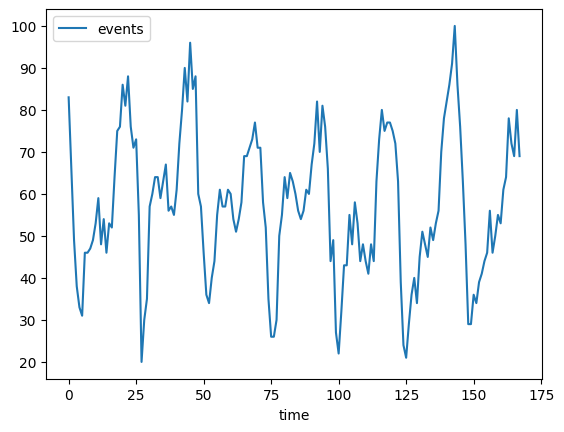

In [4]:
path = "../../data/AnneFrank.csv"
AnneFrank = pd.read_csv(path, header=1, names=['time', 'events'])
AnneFrank['date'] = pd.to_datetime(AnneFrank.time)
AnneFrank['time'] = AnneFrank['date'].astype(int) / 3600000000000
AnneFrank['time'] = AnneFrank['time'] - AnneFrank['time'].min()
AnneFrank.plot(x='time', y='events');

In this question you will fit a model to the response based on $2p+1$ predictors of the form:
$$
\begin{align}
x_1 = [1,~\ldots~,1]
\end{align}
$$
$$
\begin{align}
x_{2k} & = \sin(2 \pi \cdot k \cdot t / 48) \\
x_{2k+1} & = \cos(2 \pi \cdot k \cdot t / 48), \qquad k=1,\ldots,p
\end{align}
$$
You will then use the selected model to predict the number of events in future times. 

1. Write a function ``generate_Z`` that recieves as inputs a vector of time indices (representing hours) ``t`` and ``p``. The function returns the design matrix $Z$ of size $n \times (2p+1)$, where $n$ is the length of ``t``.
2. For each $p=1,\ldots,30$, fit a linear model to ``events`` based on $Z$ you obtain from ``generate_Z`` and evalaute its leave-one-out CV error. Plot the CV error versus $p$. 
3. Report on the model with the lowest CV error; plot its response over time along with the original response in the figure above. 
4. Using the model you found in 3, predict the number of event at times $t=168.\ldots,190$. Plot your prediction over time in the same figure as above, i.e., interpolate the response curve to future value. 
5. For each $t$ in 4, construct a 0.95 prediction interval of your prediction of $y_t$, $t=168,\ldots,190$. Plot the upper and lower limits of this interval over time (these lines define a prediction band). Is this prediction band reliable? what can go wrong? 

Hints: (2) In order to evalaute the CV error, you'll need the hat matrix (which you can get directly from Z) and the residuals in the LS fit (which you can get from the ``resid`` property of the fitted model object returned by ``statsmodels.api.OLS.fit``). (4) you can use the function ``predict`` of the fitted model object by passing new predictors that you generate using ``generate_Z``. For (5), $s^2$ is given by the property ``mse_resid`` (or ``ssr`` divided by the number of degrees of freedom). Also note that the number of degrees of freedom is $n-(2p+1)$ where $p$ is the number you found in 3. 

In [5]:
def generate_Z(t, p):
    """
    Args:
    ----
    t:   vector of time samples (length n)
    p:   number of frequencies (overal 2p+1 predictors)
    
    Returns:
    --------
    Z:  design matrix of size (n, 2p+1)
    """
    
    # Your code goes here
    
    pass

## Problem 4: Violation of Assumptions

In this problem you work with the model you fitted in Problem 3 to the data ``AnneFrank``. Make sure you used ``statsmodels`` and printed the model diagnostic information, e.g. using ``model.summary()``
1. What can you say about the assumption that the residuals follow a normal distribution? Which statistic provides relevant information?
2. Plot the model residuals over time. Make a 1-lag residuals plot $\hat{\epsilon}_{i+1}$ vs. $\hat{\epsilon}_{i}$. Do the residual look dependent over time or not? Which statistic provide relevant information?
3. A Fourier analysis reveals that there exist dominant periodic components of time period $20$ hours and $30$ hours in the residuals (you don't have to do the analysis). Argue that this is the case by regressing the residuals over the predictors $x_{1t} = \cos(2\pi t/20)$, $x_{2t} = \sin(2\pi t/20)$, $x_{3t} = \cos(2\pi t/30)$ and $x_{4t} = \sin(2\pi t/30)$, $t=1,\ldots,167$. Indicate how you can deduce that the new model makes sense. 
4. What can you say about the 1-lag correlation of the residuals of the new model? 


## Problem 4: A/B Testing


### 1. What is A/B Testing?

**A/B testing**, also called a **split test** or **controlled experiment**, is a randomized experiment where you compare two (or more) variants of an intervention (e.g., a webpage design, a marketing campaign, or a new drug formulation) to determine which variant performs better according to a pre-defined metric.

1. **Variant A (Control)** – The existing version or baseline.
2. **Variant B (Treatment)** – The new version or proposed change.

The goal is to **measure the causal impact** of switching from A to B on the outcome metric of interest (e.g., conversion rate, average revenue, click-through rate).

<br>

### 2. Why to A/B Test?

A/B tests are a form of **controlled experiment**. By randomly assigning participants (users, subjects) to either variant A or variant B, we aim to **isolate the effect** of the intervention from **confounding factors**. Randomization ensures:

1. **Independence**: Each participant’s assignment to A or B is independent of others.
2. **Balance of Covariates**: On average, both known and unknown confounders (e.g., demographics, user behavior) should be balanced across groups—so the only systematic difference is the intervention itself.

This setting allows us to make **causal inferences** about whether variant B truly improves (or worsens) the key metric compared to A.

<br>

### 3. Setting Up the Experiment

#### 3.1 Defining the Metric

Before launching an A/B test, precisely define the **primary outcome metric** you wish to measure. Common examples:
- **Binary**: Conversion (1 = purchased, 0 = did not purchase).
- **Continuous**: Average time on site, average transaction value, etc.
- **Count**: Number of pages visited, items purchased, etc.

#### 3.2 Random Assignment and Data Collection

- **Randomization**: Each incoming participant is assigned to Group A or Group B with probability 0.5 (or another specified proportion).
- **Sample Size**: Use **power analysis** (or a pre-determined plan) to determine how many participants you need to detect a specified effect size at a chosen significance level $ \alpha $ (often 0.05) with adequate power.
- **Duration**: Continue the experiment until you reach that sample size or a specific time horizon.


<br>

### 4. Statistical Framework

#### 4.1 Formulating the Hypotheses

##### Nominal Response

If we denote $ \mu_A $ as the true mean response for the Control group and $ \mu_B$ for the Treatment group:

- **Null Hypothesis ($ H_0 $)**:
  $ \mu_A = \mu_B $

- **Alternative Hypothesis ($ H_1 $)**
  $ \mu_A \neq \mu_B $
  
##### Binary Response
If we denote $ p_A $ as the true parameter (e.g., conversion rate) for the Control group and $ p_B $ for the Treatment group:

- **Null Hypothesis ($ H_0 $)**:
  $ p_A = p_B $
  (No difference in performance between variants.)

- **Alternative Hypothesis ($ H_1 $)** (Two-sided):
  $ p_A \neq p_B $
  (There is a difference—could be an increase or a decrease.)


<br>

#### 4.2 Test Statistic and Distribution

##### Nominal Response
Use the two-sample $t$-test

##### Binary Response
Use the **two-proportion z-test**:

$ Z = \frac{\hat{p}_A - \hat{p}_B}{\sqrt{\hat{p}(1 - \hat{p})\left(\frac{1}{n_A} + \frac{1}{n_B}\right)}} $

where:
- $ \hat{p}_A $ = observed proportion for Group A (e.g., $ \text{conversions}_A / n_A $)
- $ \hat{p}_B $ = observed proportion for Group B
- $ n_A, n_B $ = number of observations in Groups A and B
- $ \hat{p} $ = "pooled" proportion across both groups (since $ H_0 $ posits $ p_A = p_B $):
  $ \hat{p} = \frac{\#\{\text{conversions in A}\} + \#\{\text{conversions in B}\}}{n_A + n_B} $


You will later prove that under the null hypothesis $p_A=p_B$ and in the large samples sizes limit $n_A \to \infty$ and $n_B\to \infty$, this $ Z $-statistic approximately follows a standard normal ($ N(0, 1) $) distribution.

This leads to the following procedure:

1. **Compute $ Z $**.
2. **Obtain p-value**: Probability of observing a $ Z $-statistic at least as extreme as the observed one, assuming the null hypothesis is true.
3. **Decision**: If $ p\text{-value} < \alpha $, reject $ H_0 $. Otherwise, fail to reject $ H_0 $.

<br>

#### 4.3 Assumptions

1. **Random Assignment**: Observations are randomly allocated to A or B.
2. **Independence**: Observations within and across groups are independent.
3. **Sufficient Sample**: Each group should have at least 5–10 observed successes **and** failures to ensure the normal approximation is valid.
4. **No Major Time Trends**: The underlying conversion probabilities do not drift drastically over the test period.

<br>

### 5. Summary

1. **Concept**: A/B testing is a **randomized controlled experiment** comparing two variants (A=Control, B=Treatment).
2. **Hypothesis**: Typically, $ H_0: p_A = p_B $ vs. $ H_1: p_A \neq p_B $.
3. **Implementation**:
   - Randomly assign users to A or B.
   - Collect data on your primary outcome metric.
   - Use a suitable **statistical test**.
   - Evaluate statistical significance ($ p $-value < $ \alpha $).
4. **Interpretation**:
   - Reject $ H_0 $ if $ p $-value < $ \alpha $ → significant difference in performance.
   - Otherwise, fail to reject $ H_0 $.

By properly designing and analyzing an A/B test, we can **establish a causal link** between design changes (B vs. A) and measured outcomes, which is the cornerstone of **data-driven decision-making** in many industries.


## Assignments:

4.1. Prove that under the null hypothesis $p_A=p_B$ and in the large samples sizes limit $n_A \to \infty$ and $n_B\to \infty$, the $ Z $-statistic presented above converges to a standard normal ($ N(0, 1) $) distribution. Use the following steps:
1. Show that under $H_0$, $\hat{p} \to p_A$ in distribution (Note: this is convergence of a random variable to a constant. Use the law of large numbers)
2. Evaluate the variance of $\hat{p}_A - \hat{p}_B$. 
3. Argue that $(\hat{p}_A - \hat{p}_B)/\sqrt{\mathrm{Var}(\hat{p}_A - \hat{p}_B)}$ converges in distribution to a standard normal. Use the central limit theorem.
4. Argue that $Z$ converges to a standard normal distribution. Use the following fact (Slutsky's Theorem): for two sequences of random variables $\{X_n\}$ and $\{Y_n\}$, if $X_n \to X$ in distribution and $Y_n \to c>0$ (a non-zero constant), then $X_n/Y_n \to X/c$ in distribution.

4.2. Practice A/B testing using the dataset 'ab_test_data.csv'. This dataset contains the results of an A/B test where two groups (A and B) were exposed to different versions of a website. The data includes the group assignment, the conversion rate (0/1) and the revenue for each user.
1. Perform an A/B test to compare the conversion rates and average revenue between groups A and B. Explicitly state assumptions, hypotheses, statistical tools you used and conclusions.
2. The CEO would like to know the bottom line: does the new version of the website improve its performance? What would you tell the CEO? (Remember that you conducted multiple tests, so you should support your recommendation with statistical evidence).

